In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
#usando odfpy para ler os arquivos excel
itens = pd.read_excel('itens.ods', engine='odf')
pedidos = pd.read_excel('pedidos.ods', engine='odf')
itens_pedidos = pd.read_excel('itens_pedidos.ods', engine='odf')

print('Itens: \n', itens.head(),'\n')
print('Pedidos: \n', pedidos.head(),'\n')
print('Itens Pedidos: \n', itens_pedidos.head())

Itens: 
     ITEM   VALOR
0  item A     10
1  item B     15
2  item C     20
3  item D     25 

Pedidos: 
    Unnamed: 0  ID_PEDIDO        DATA  VALOR_TOTAL
0           0  120210601  2021-06-01          NaN
1           1  220210601  2021-06-01          NaN
2           2  320210604  2021-06-04          NaN
3           3  420210604  2021-06-04          NaN
4           5  520210604  2021-06-04          NaN 

Itens Pedidos: 
    Unnamed: 0  ID_PEDIDO ID_ITEM  QUANTIDADE
0           0  120210601  item C           4
1           1  220210601  item A           3
2           2  320210604  item C           1
3           3  420210604  item B           4
4           4  420210604  item C           2


In [3]:
itens.columns = ['Item', 'Valor']
pedidos.columns = ['', 'ID_Pedido', 'Data', 'Valor_Total']
itens_pedidos.columns = ['', 'ID_Pedido', 'ID_Item', 'Quantidade']

In [4]:
#merge para unir os itens e seus valores com os itens pedidos
merged_df = pd.merge(itens_pedidos, itens, left_on = 'ID_Item', right_on = 'Item')

In [5]:
#calcula valor total de cada pedido
merged_df['Valor_Itens'] = merged_df['Quantidade'] * merged_df['Valor'] 

In [6]:
valor_total_por_pedido = merged_df.groupby('ID_Pedido')['Valor_Itens'].sum().reset_index()
valor_total_por_pedido.columns = ['ID_Pedido', 'Valor_Total']
    
print(valor_total_por_pedido.head(), '\n')

   ID_Pedido  Valor_Total
0  120210601           80
1  220210601           30
2  320210604           20
3  420210604          100
4  520210604           30 



In [7]:
pedidos = pd.merge(pedidos, itens_pedidos[['ID_Pedido', 'ID_Item', 'Quantidade']], on = 'ID_Pedido', how = 'left')

pedidos = pd.merge(pedidos, valor_total_por_pedido, on = 'ID_Pedido', how = 'left', suffixes=('_x', '_y'))


In [8]:
pedidos['Quantidade'] = pedidos['Quantidade'].fillna(0)
pedidos['Valor_Total'] = pedidos['Valor_Total_y'].fillna(0)

In [9]:
pedidos = pedidos.drop(columns = ['Valor_Total_x', 'Valor_Total_y'])

In [10]:
pedidos = pedidos[['', 'ID_Pedido', 'Data', 'ID_Item', 'Quantidade', 'Valor_Total']]

In [11]:
pedidos.to_excel('Pedidos_Atualizados.ods', index = False, engine = 'odf')

print('Arquivo Salvo com sucesso.')

Arquivo Salvo com sucesso.


In [12]:
### ANALISES ###

Pedidos_Atualizados = pd.read_excel('Pedidos_Atualizados.ods', engine='odf')
Pedidos_Atualizados['Data'] = pd.to_datetime(Pedidos_Atualizados['Data'])

# Numero total de pedidos para cada item
numero_pedidos_por_item = Pedidos_Atualizados.groupby('ID_Item')['ID_Pedido'].nunique().reset_index()
numero_pedidos_por_item.columns = ['ID_Item', 'Numero_Pedidos']

# Numero total de itens vendidos para cada item
numero_itens_vendidos = Pedidos_Atualizados.groupby('ID_Item')['Quantidade'].sum().reset_index()
numero_itens_vendidos.columns = ['ID_Item', 'Total_Itens_Vendidos']

# Quantidade media de cada item por pedido
quant_media_por_item = Pedidos_Atualizados.groupby('ID_Item')['Quantidade'].mean().reset_index()
quant_media_por_item.columns = ['ID_Item', 'Quant_Media_Por_Pedido']

# Valor total faturado para cada item
Pedidos_Atualizados['Valor_Total_Item'] = Pedidos_Atualizados['Quantidade'] * Pedidos_Atualizados['Valor_Total']
valor_total_por_item = Pedidos_Atualizados.groupby('ID_Item')['Valor_Total_Item'].sum().reset_index()
valor_total_por_item.columns = ['ID_Item', 'Valor_Total_Faturado']

print('Número total de pedidos para cada item:\n', numero_pedidos_por_item, '\n')
print('Número total de itens vendidos para cada item:\n', numero_itens_vendidos, '\n')
print('Quantidade média de cada item por pedido:\n', quant_media_por_item, '\n')
print('Valor total faturado para cada item:\n', valor_total_por_item, '\n')

Número total de pedidos para cada item:
   ID_Item  Numero_Pedidos
0  item A              65
1  item B              72
2  item C              67
3  item D              76 

Número total de itens vendidos para cada item:
   ID_Item  Total_Itens_Vendidos
0  item A                   211
1  item B                   217
2  item C                   216
3  item D                   251 

Quantidade média de cada item por pedido:
   ID_Item  Quant_Media_Por_Pedido
0  item A                3.149254
1  item B                2.972603
2  item C                3.000000
3  item D                3.024096 

Valor total faturado para cada item:
   ID_Item  Valor_Total_Faturado
0  item A                 22295
1  item B                 23770
2  item C                 30860
3  item D                 35410 



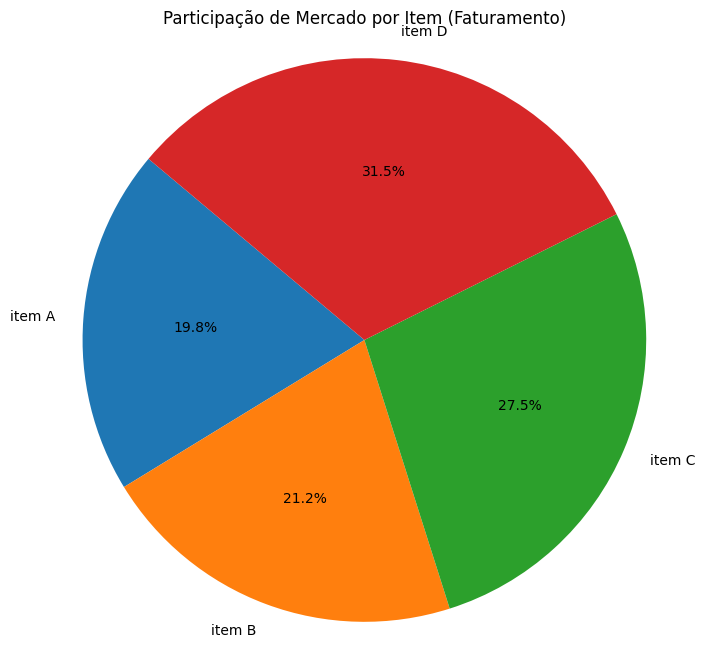

In [13]:
# Calculando o faturamento total
faturamento_total = valor_total_por_item['Valor_Total_Faturado'].sum()

# Calculando a participação de mercado de cada item
valor_total_por_item['Participacao'] = valor_total_por_item['Valor_Total_Faturado'] / faturamento_total

# Plotando o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(valor_total_por_item['Participacao'], labels=valor_total_por_item['ID_Item'], autopct='%1.1f%%', startangle=140)
plt.title('Participação de Mercado por Item (Faturamento)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


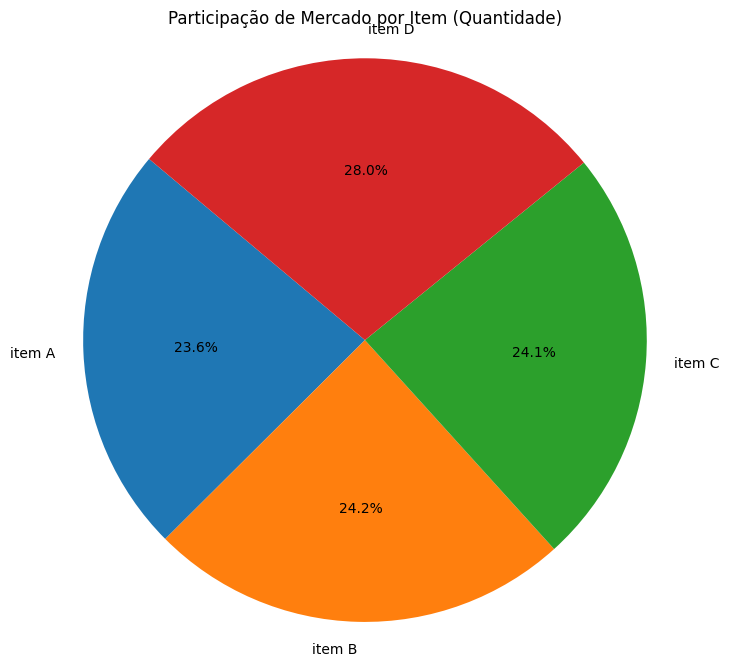

In [14]:
total_itens_vendidos = numero_itens_vendidos['Total_Itens_Vendidos'].sum()

# Calculando a participação de mercado de cada item com base na quantidade vendida
numero_itens_vendidos['Participacao'] = numero_itens_vendidos['Total_Itens_Vendidos'] / total_itens_vendidos

# Plotando o gráfico de pizza
plt.figure(figsize=(8, 8))
plt.pie(numero_itens_vendidos['Participacao'], labels=numero_itens_vendidos['ID_Item'], autopct='%1.1f%%', startangle=140)
plt.title('Participação de Mercado por Item (Quantidade)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Faturamento Mensal:     Ano_Mes  Faturamento_Total
0  2021-06               7635
1  2021-07              13950
2  2021-08              11365
3  2021-09                230 



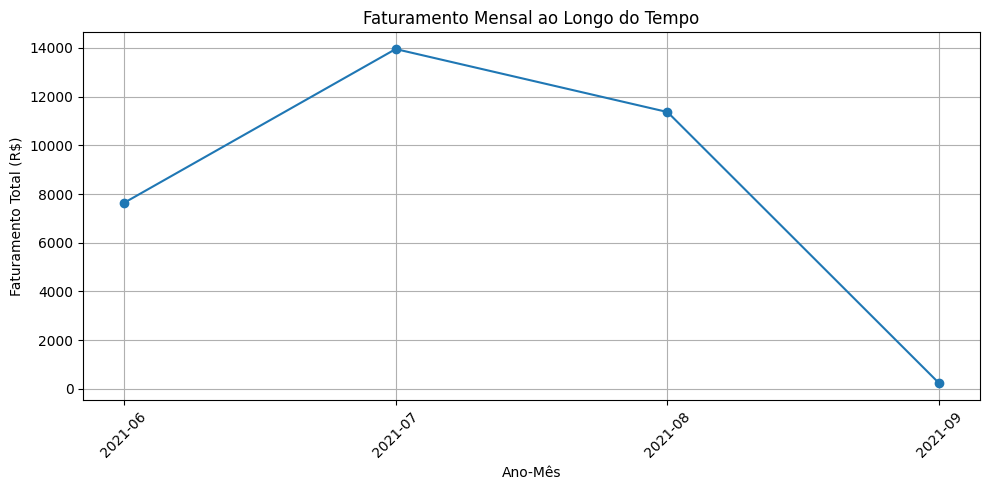

In [15]:
#Valor faturado em periodos especificos do ano
Pedidos_Atualizados['Ano_Mes'] = Pedidos_Atualizados['Data'].dt.to_period('M')
faturamento_mensal = Pedidos_Atualizados.groupby('Ano_Mes')['Valor_Total'].sum().reset_index()
faturamento_mensal.columns = ['Ano_Mes', 'Faturamento_Total']

print('Faturamento Mensal: ', faturamento_mensal, '\n')

plt.figure(figsize=(10, 5))
plt.plot(faturamento_mensal['Ano_Mes'].astype(str), faturamento_mensal['Faturamento_Total'], marker='o')
plt.xlabel('Ano-Mês')
plt.ylabel('Faturamento Total (R$)')
plt.title('Faturamento Mensal ao Longo do Tempo')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

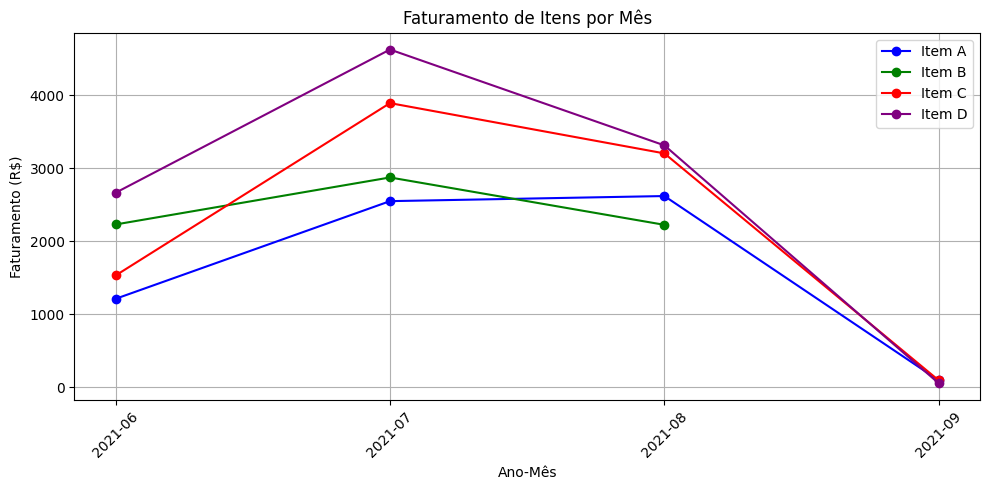

In [16]:
# Agrupando o faturamento de cada item por mês
faturamento_por_mes = Pedidos_Atualizados.groupby(['ID_Item', Pedidos_Atualizados['Data'].dt.to_period('M')])['Valor_Total'].sum().reset_index()

cores = {'A': 'blue', 'B': 'green', 'C': 'red', 'D': 'purple'}

plt.figure(figsize=(10, 5))

# Plotando uma linha para o faturamento de cada item
for item, df in faturamento_por_mes.groupby('ID_Item'):
    item_sem_prefixo = item.replace('item ', '') 
    cor = cores.get(item_sem_prefixo, 'black') 
    plt.plot(df['Data'].astype(str), df['Valor_Total'], marker='o', label=f'Item {item_sem_prefixo}', color=cor)

plt.xlabel('Ano-Mês')
plt.ylabel('Faturamento (R$)')
plt.title('Faturamento de Itens por Mês')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

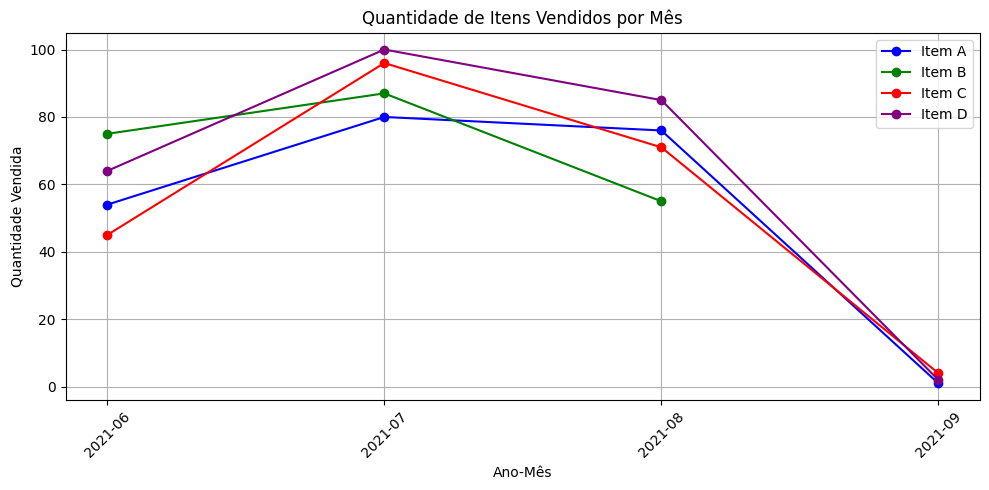

In [17]:
# Agrupando a quantidade de cada item vendido em cada mês
vendas_por_mes = Pedidos_Atualizados.groupby(['ID_Item', Pedidos_Atualizados['Data'].dt.to_period('M')])['Quantidade'].sum().reset_index()

plt.figure(figsize=(10, 5))

# Plotando uma linha para cada tipo de item
for item, df in vendas_por_mes.groupby('ID_Item'):
    item_sem_prefixo = item.replace('item ', '') 
    cor = cores.get(item_sem_prefixo, 'black')   
    plt.plot(df['Data'].astype(str), df['Quantidade'], marker='o', label=f'Item {item_sem_prefixo}', color=cor)

plt.xlabel('Ano-Mês')
plt.ylabel('Quantidade Vendida')
plt.title('Quantidade de Itens Vendidos por Mês')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

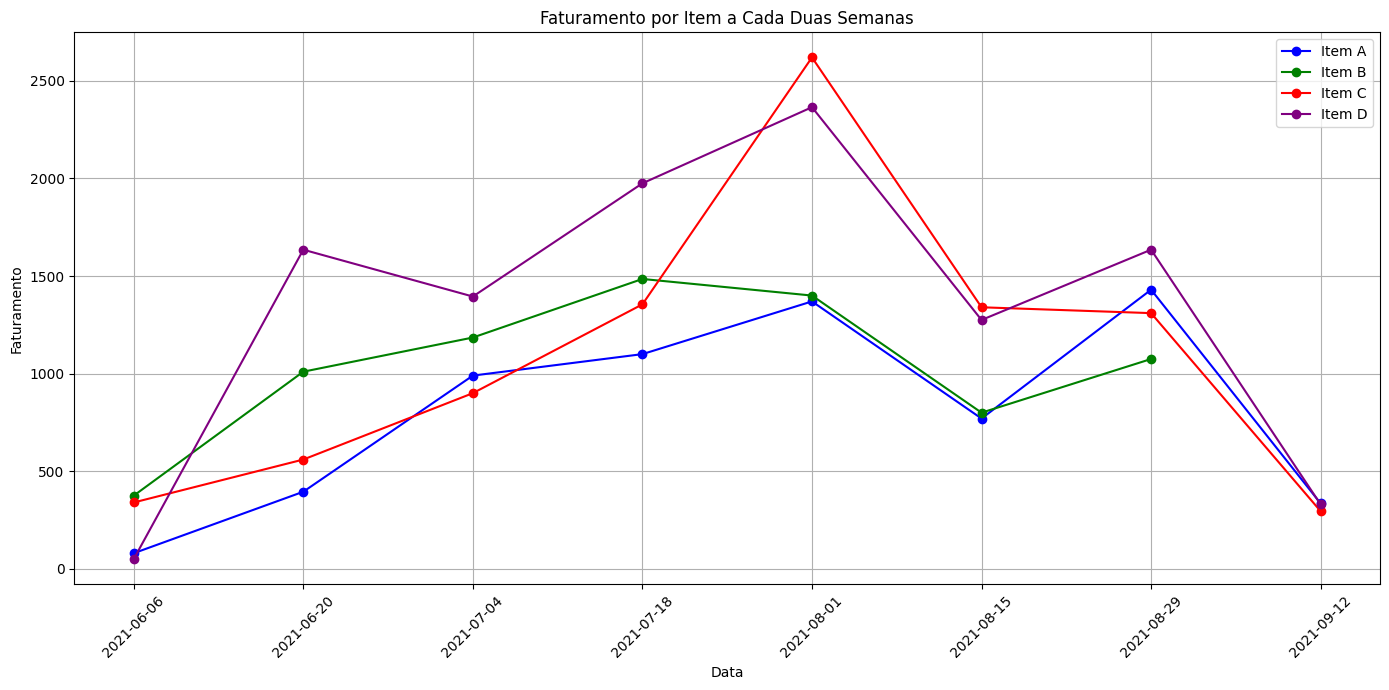

In [18]:
Pedidos_Atualizados['Data'] = pd.to_datetime(Pedidos_Atualizados['Data'])

faturamento_quinzenal = Pedidos_Atualizados.groupby(['ID_Item', pd.Grouper(key='Data', freq='2W')])['Valor_Total'].sum().reset_index()

plt.figure(figsize=(14, 7))

for item, df in faturamento_quinzenal.groupby('ID_Item'):
   item_sem_prefixo = item.replace('item ', '') 
   cor = cores.get(item_sem_prefixo, 'black')   
   plt.plot(df['Data'].astype(str), df['Valor_Total'], marker='o', label=f'Item {item_sem_prefixo}', color=cor)

plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.title('Faturamento por Item a Cada Duas Semanas')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

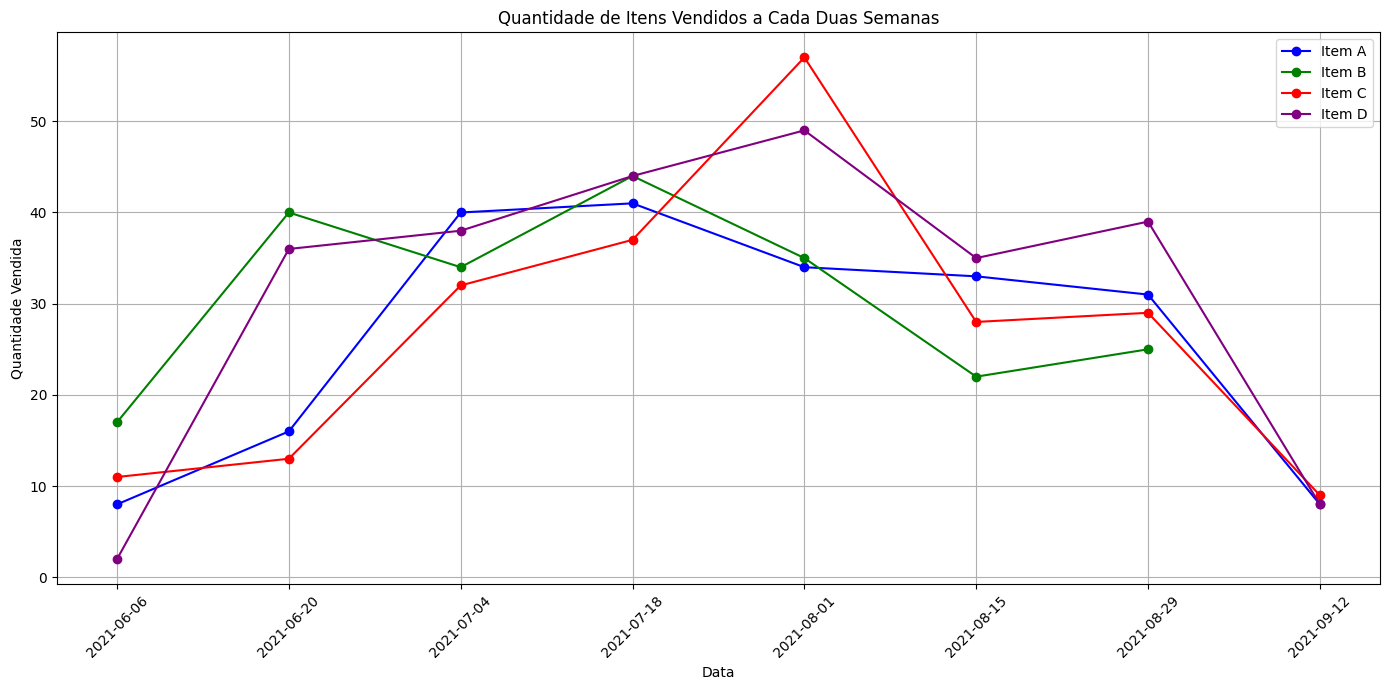

In [19]:
Pedidos_Atualizados['Data'] = pd.to_datetime(Pedidos_Atualizados['Data'])

vendas_quinzenais = Pedidos_Atualizados.groupby(['ID_Item', pd.Grouper(key = 'Data', freq = '2W')])['Quantidade'].sum().reset_index()

plt.figure(figsize=(14, 7))

for item, df in vendas_quinzenais.groupby('ID_Item'):
   item_sem_prefixo = item.replace('item ', '') 
   cor = cores.get(item_sem_prefixo, 'black')   
   plt.plot(df['Data'].astype(str), df['Quantidade'], marker='o', label=f'Item {item_sem_prefixo}', color=cor)

plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.title('Quantidade de Itens Vendidos a Cada Duas Semanas')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
#iremos usar regressão linear

In [21]:
data_limite = pd.to_datetime('2021-09-01')
dados_filtrados = Pedidos_Atualizados[Pedidos_Atualizados['Data'] < data_limite]

vendas_diarias = dados_filtrados.groupby(['ID_Item', 'Data'])['Quantidade'].sum().reset_index()

In [22]:
# Preparando os dados para a regressão linear
X = vendas_diarias[['Data']]
X.loc[:, 'Data_Num'] = X['Data'].map(pd.Timestamp.toordinal) # .loc para evitar erro de modificacao de dataframe

y = vendas_diarias['Quantidade']

/tmp/ipykernel_8112/1183998140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Data_Num'] = X['Data'].map(pd.Timestamp.toordinal) # .loc para evitar erro de modificacao de dataframe


In [23]:
# Dividindo os dados em treino e teste 
X_train, X_test, y_train, y_test = train_test_split(X[['Data_Num']], y, test_size=0.2, random_state=42)

In [24]:
# Treinando o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [25]:
# Fazendo previsões no conjunto de teste
y_pred = modelo.predict(X_test)

In [26]:
# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Erro quadrático médio (MSE): {mse}')

Erro quadrático médio (MSE): 4.393404686853624


In [27]:
# Previsão das vendas de setembro
ultimo_dia_setembro = pd.to_datetime('2021-09-30')  
primeiro_dia_setembro = pd.to_datetime('2021-09-01') 
ultimo_dia_setembro_num = ultimo_dia_setembro.toordinal()
primeiro_dia_setembro_num = primeiro_dia_setembro.toordinal()

In [28]:
# Calculando as previsões diárias de setembro
datas_setembro = pd.date_range(start=primeiro_dia_setembro, end=ultimo_dia_setembro)
datas_setembro_num = datas_setembro.to_series().apply(lambda x: x.toordinal())
quantidades_pred = modelo.predict(datas_setembro_num.values.reshape(-1, 1))

/home/eduardo/my_jupyter_env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [29]:
quantidade_pred_total = quantidades_pred.sum()

print(f'Predição de vendas para setembro de 2021: {quantidade_pred_total}')

Predição de vendas para setembro de 2021: 112.8147014106853
